#Homework 5: Confusion Matrix. ROC. AUC.

# Part 1
You will predict for an insuarance company how likely the person will be admitted to a hospital within the next year `DaysInHospital_Y2.csv`. The following data is provided: paitients' information `Members.csv` (age, sex) medical services provided in the previous year `Claims_Y1.csv` (provider, doctor, illness, days in hospital, etc. ).
Data source: https://www.kaggle.com/competitions/hhp/overview

You can dounload files directly from https://github.com/truongkhanhduy95/Heritage-Health-Prize/tree/master/data (click *Raw data* and copy the path). **If you use this repo, use 'Claims.csv' instead of 'Claims_Y1.csv'**

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#1. (1pt) Read the data using parameter index_col = `MemberID`.

* table 'DaysInHospital_Y2.csv' into variable `days2`
* table 'Members.csv' into variable `m`
* table 'Claims_Y1.csv' into variable `claims`

In [79]:
path = 'https://media.githubusercontent.com/media/truongkhanhduy95/Heritage-Health-Prize/master/data/'

In [80]:
m=pd.read_csv(path+'Members.csv',index_col='MemberID')
m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70-79,M
75706636,70-79,M
17320609,70-79,M
69690888,40-49,M
33004608,0-9,M


In [81]:
claims=pd.read_csv(path+'Claims.csv',index_col='MemberID')
claims.head()

,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
MemberID,,,,,,,,,,,,,
42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
97903248,3316066.0,726296.0,5300.0,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2759427,2997752.0,140343.0,91972.0,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
73570559,7053364.0,240043.0,70119.0,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
11837054,7557061.0,496247.0,68968.0,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [82]:
days2=pd.read_csv(path+'DaysInHospital_Y2.csv',index_col='MemberID')
days2.head()

,ClaimsTruncated,DaysInHospital
MemberID,,
24027423,0,0
98324177,0,0
33899367,1,1
5481382,0,1
69908334,0,0


To anonymize the data, the organizer provided approximate information about patients, for example, in the Age column, age groups are specified: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. We will convert string features into numerical ones and replace missing values.

In [83]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s.split('-')[0]) if s!='80+' else 80)

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

<ipython-input-83-a189b6f0acbb>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)


Let's construct features based on the array of medical service cases:
* `f_Charlson` — the maximum Charlson comorbidity index among all cases for the patient (`CharlsonIndex` in the table `claims`)
* `f_LengthOfStay` —  the total number of hospitalization days in the past year  (`LengthOfStay` in the table `claims`)


In [84]:
f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max()
f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum()

We will create a feature matrix with the following columns: `f_Charlson`, `f_LengthOfStay`, `AgeAtFirstClaim`, `ClaimsTruncated` (whether there were too many medical service cases).

In [85]:
y = (days2['DaysInHospital']>0).astype('int').values
X = days2[['ClaimsTruncated']]
X = X.join(f_Charlson)
X = X.join(f_LengthOfStay)
X = X.join(m.AgeAtFirstClaim)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim
MemberID,,,,
24027423,0,3,0,30
98324177,0,0,0,30
33899367,1,0,0,80
5481382,0,0,1,20
69908334,0,1,0,60


## 2. (3pt) Add to the features columm `Sex`

In [86]:
X = X.join(m.Sex)
X.head()

,ClaimsTruncated,CharlsonIndex,LengthOfStay,AgeAtFirstClaim,Sex
MemberID,,,,,
24027423,0,3,0,30,M
98324177,0,0,0,30,M
33899367,1,0,0,80,F
5481382,0,0,1,20,F
69908334,0,1,0,60,F


## 3. (1pt) Split the date X and y into Train/Validation/Test sets in the following proportion: 50/25/25.

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
#split the data 50/25/25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

##4. (2pt) The column `Sex` contains missing values. Create the column transformer that will apply One-Hot-Encoder to this column with parameter `handle_unknown='infrequent_if_exist'`. It will create automatically `'OneHot__Sex_nan'` column afer fitting this transformer on the Train set. (Don't forget parameter `reminder`)

In [89]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [90]:
#create column transformer that applies one hot encoder to 'Sex' column
transformer = ColumnTransformer([('OneHot', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['Sex'])], remainder='passthrough')

#fit on training data
transformer.fit(X_train)

#transform the training, validation, and test sets
X_train_transformed = transformer.transform(X_train)
X_val_transformed = transformer.transform(X_val)
X_test_transformed = transformer.transform(X_test)

#print shape of transformed sets
print(X_train_transformed.shape)
print(X_val_transformed.shape)
print(X_test_transformed.shape)

#print new feature names
feature_names = transformer.get_feature_names_out()
print(feature_names)


(38019, 7)
(19009, 7)
(19010, 7)
['OneHot__Sex_F' 'OneHot__Sex_M' 'OneHot__Sex_nan'
 'remainder__ClaimsTruncated' 'remainder__CharlsonIndex'
 'remainder__LengthOfStay' 'remainder__AgeAtFirstClaim']


## 5. (3pt) Create a pipeline for training logistic regression. It should include transformation, scaling, and model. And fit it on the Training set

In [91]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [92]:
#build and fit the pipeline on the training set
pipe = Pipeline([('transformer', transformer), ('scaler', StandardScaler()), ('model', LogisticRegression())])
pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['Sex'])])),
                ('scaler', StandardScaler()), ('model', LogisticRegression())])

## 6. (2pt) Plot ROC-AUC and Confusion Matrix. Report the Recall value.

In [93]:
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, RocCurveDisplay, roc_auc_score

In [94]:
y_pred = pipe.predict(X_val)
print(recall_score(y_val, y_pred))

0.025257560651379195


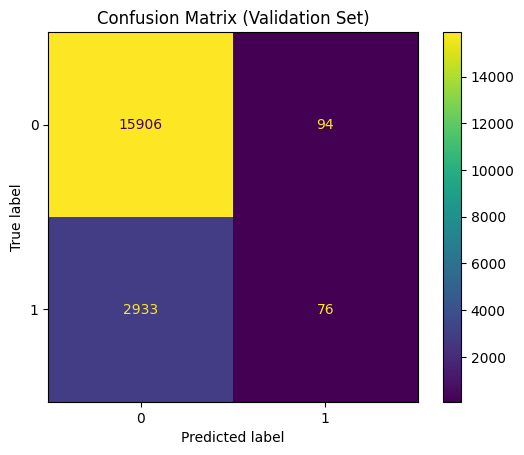

In [95]:
#plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [96]:
#calculate recall
recall_val = recall_score(y_val, y_pred)
print('Recall:', recall_val)

Recall: 0.025257560651379195


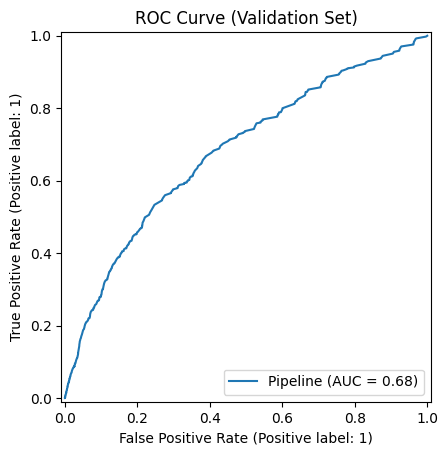

In [97]:
#plot ROC cruve
RocCurveDisplay.from_estimator(pipe, X_val, y_val)
plt.title('ROC Curve (Validation Set)')
plt.show()

## 7. (4pt) Use `.predict_proba` to get the values in the interval $[0,\ 1]$ instead of the classes 0 or 1.

Choose the threshold, such that recall on the Validation set is $>0.5$ (Think about this as the insuarance company's requirement.)

For the chosen threshold plot ROC-AUC (it won't change because the model stays unchanged) and Confusion Matrix. Report the Recall value.

In [98]:
#get predicted probabilities for the positive class
y_val_pred_proba = pipe.predict_proba(X_val)[:, 1]
print(y_val_prob)

[0.08535612 0.14702746 0.10497433 ... 0.40463516 0.07939422 0.10192135]


In [108]:
#loop over thresholds (between 0 and 1) to find the highest threshold with recall > 0.5

thresholds = np.linspace(1, 0, 101)
chosen_threshold = None
chosen_recall = None

for threshold in thresholds:
    y_val_pred = (y_val_prob > threshold).astype(int)
    recall = recall_score(y_val, y_val_pred)
    if recall > 0.5:
        chosen_threshold = threshold
        chosen_recall = recall
        break

print('Chosen threshold:', chosen_threshold)
print('Chosen recall:', chosen_recall)

Chosen threshold: 0.14
Chosen recall: 0.574941841143237


In [109]:
#create predition using best threshold
y_val_pred = (y_val_prob >= chosen_threshold).astype(int)

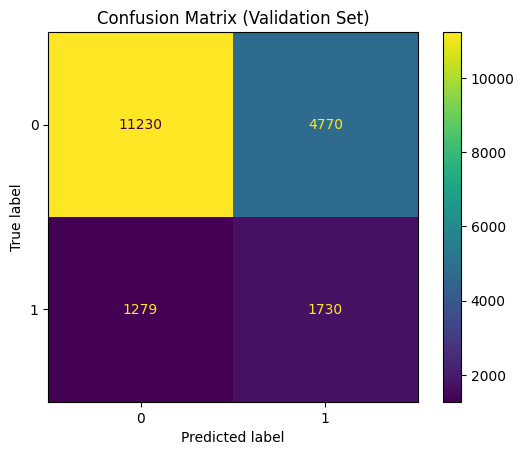

In [110]:
#plot confusion matrix with new threshold
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred)
plt.title('Confusion Matrix (Validation Set)')
plt.show()

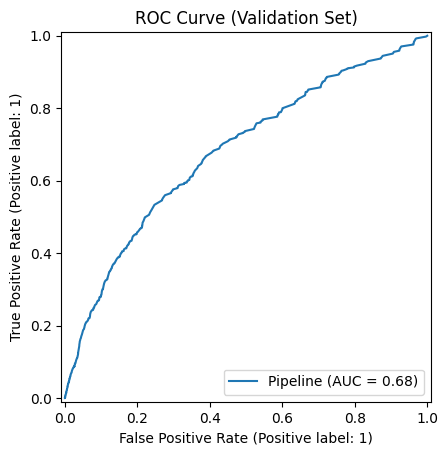

In [114]:
#plot ROC curve with new threshold
RocCurveDisplay.from_estimator(pipe, X_val, y_val)
plt.title('ROC Curve (Validation Set)')
plt.show()

## 8. (2 pt) Finally, plot ROC-AUC and Confusion Matrix, and report the Recall value on the Test set.

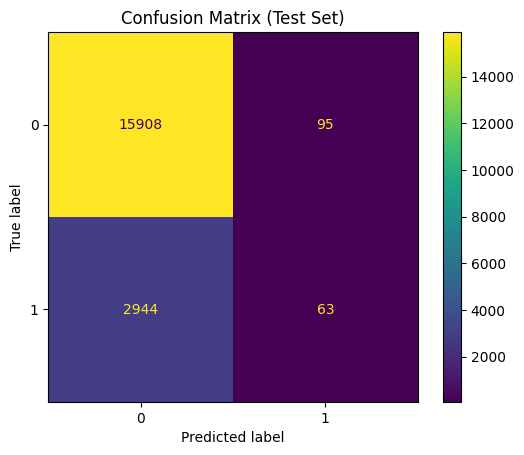


Recall: 0.020951114067176587



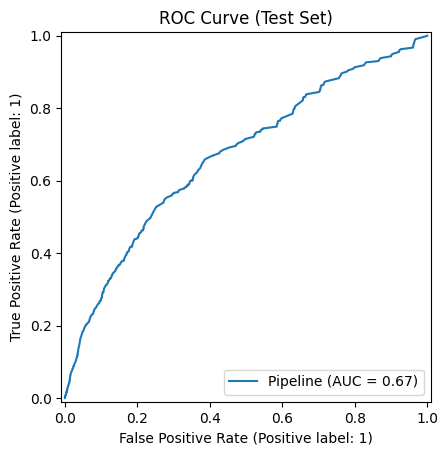

In [113]:
#plot and calculate using default threshold = 0.5

y_test_pred = pipe.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('Confusion Matrix (Test Set)')
plt.show()

recall_test = recall_score(y_test, y_test_pred)
print()
print('Recall:', recall_test)
print()

RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title('ROC Curve (Test Set)')
plt.show()

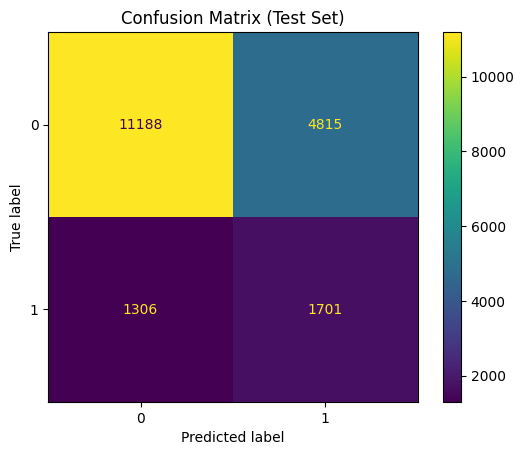


Recall: 0.5656800798137679



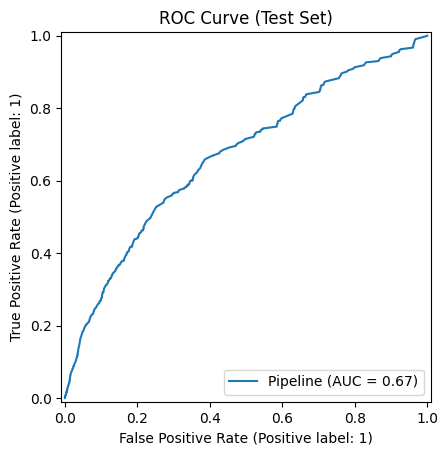

In [115]:
#plot and calculate using custom threshold

y_test_prob = pipe.predict_proba(X_test)[:,1]
y_test_pred = (y_test_prob >= chosen_threshold).astype(int)

ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('Confusion Matrix (Test Set)')
plt.show()

recall_test = recall_score(y_test, y_test_pred)
print()
print('Recall:', recall_test)
print()

RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title('ROC Curve (Test Set)')
plt.show()

## 9. (2pt) Which features are more important?

In [116]:
#extract coeffs from model
coefs = pipe.named_steps['model'].coef_[0]

#get transformed features names
feature_names = pipe.named_steps['transformer'].get_feature_names_out()

#create dataframe to display coeffs
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Absolute Coefficient': np.abs(coefs)
}).sort_values(by='Absolute Coefficient', ascending=False)

print(importance_df)

                      Feature  Coefficient  Absolute Coefficient
2             OneHot__Sex_nan     0.273914              0.273914
4    remainder__CharlsonIndex     0.230254              0.230254
3  remainder__ClaimsTruncated     0.186782              0.186782
1               OneHot__Sex_M    -0.168014              0.168014
5     remainder__LengthOfStay     0.101489              0.101489
6  remainder__AgeAtFirstClaim     0.069156              0.069156
0               OneHot__Sex_F    -0.049695              0.049695


From the sorted coefficients, OneHot__Sex_nan has the largest absolute coefficient, suggesting that missing/unknown Sex information has the strongest influence. Next come CharlsonIndex and ClaimsTruncated, both of which also show relatively large absolute coefficients and thus have a major impact on the model’s predictions. Meanwhile, LengthOfStay, AgeAtFirstClaim, and the other Sex categories have smaller absolute coefficients, indicating a comparatively lesser effect.